# Time Series Analysis

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [3]:
mobile_sales = pd.read_excel('mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [14]:
mobile_sales.head(20)

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
2001-06-01,8104.0
2001-07-01,7813.0
2001-08-01,8279.0
2001-09-01,7014.0


In [5]:
mobile_sales.shape

(217, 2)

In [8]:
mobile_sales.DATE.describe()

/var/folders/pb/lctdnpp509v1l7y5t98dvxj00000gn/T/ipykernel_19298/20359885.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  mobile_sales.DATE.describe()


count                     217
unique                    217
top       2001-01-01 00:00:00
freq                        1
first     2001-01-01 00:00:00
last      2019-01-01 00:00:00
Name: DATE, dtype: object

In [12]:
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


<AxesSubplot:xlabel='DATE'>

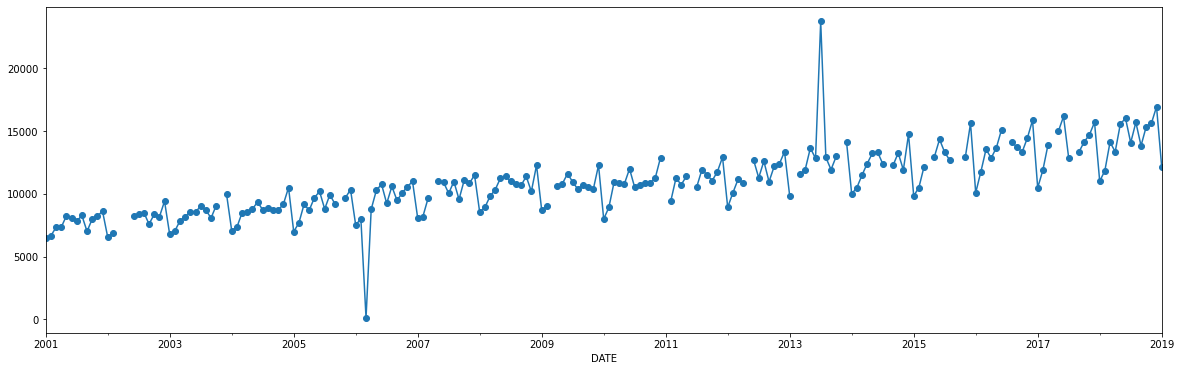

In [13]:
# mobile_sales.set_index('DATE', inplace=True)
mobile_sales.Sales.plot(style='-o')

In [ ]:
ul = mobile_sales.Sales.quantile(0.99)
ll = mobile_sales.Sales.quantile(0.01)

In [29]:
mobile_sales.Sales = mobile_sales.Sales.interpolate()
mobile_sales.Sales = mobile_sales.Sales.clip(
    upper=mobile_sales.Sales.quantile(0.99),
    lower=mobile_sales.Sales.quantile(0.01)
)

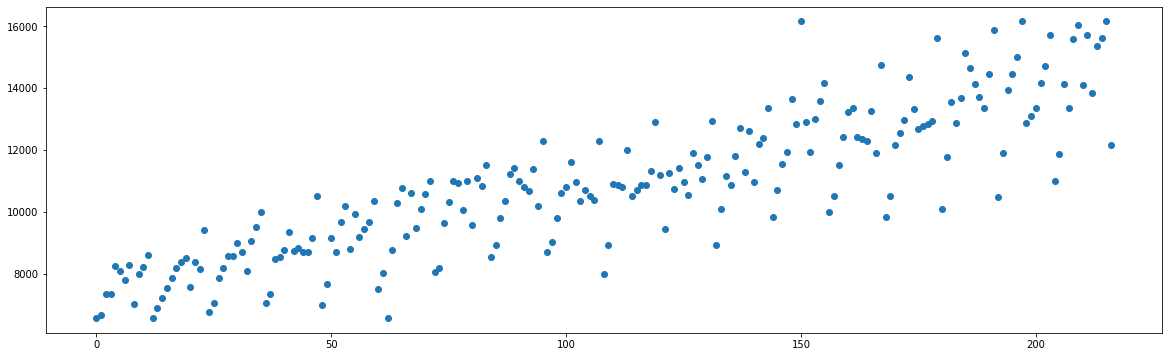

In [61]:
plt.scatter(np.arange(len(mobile_sales.Sales)), mobile_sales.Sales)

<AxesSubplot:xlabel='DATE'>

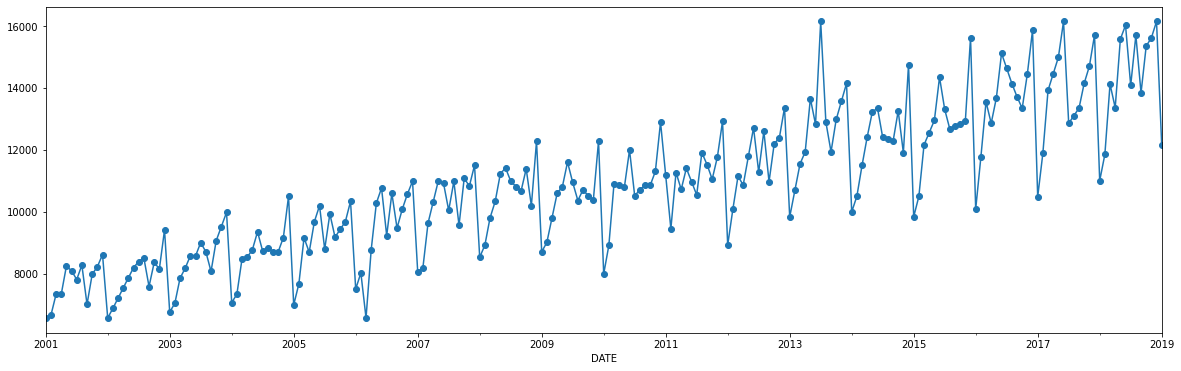

In [30]:
mobile_sales.Sales.plot(style='-o')

<AxesSubplot:xlabel='DATE'>

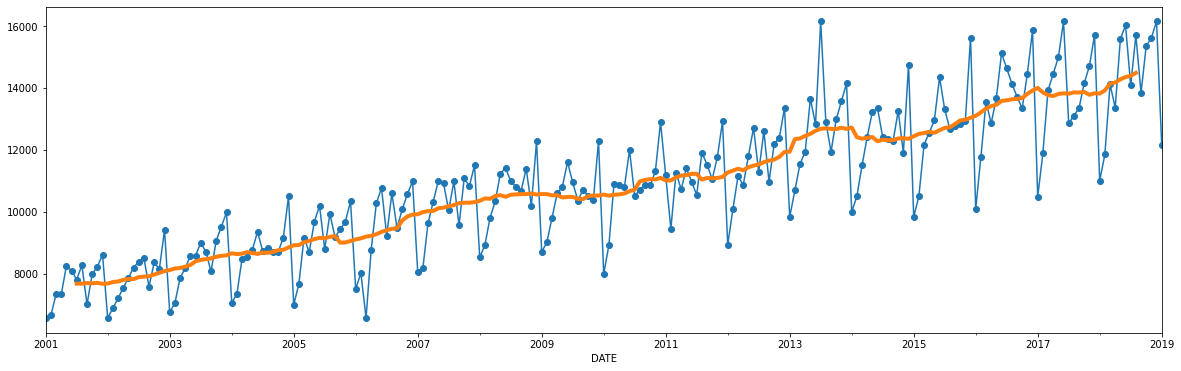

In [69]:
mobile_sales.Sales.plot(style='-o')
mobile_sales.Sales.rolling(12, center=True).mean().plot(linewidth=4)
# mobile_sales.Sales.rolling(12, center=False).mean().plot(linewidth=4)

<AxesSubplot:xlabel='DATE'>

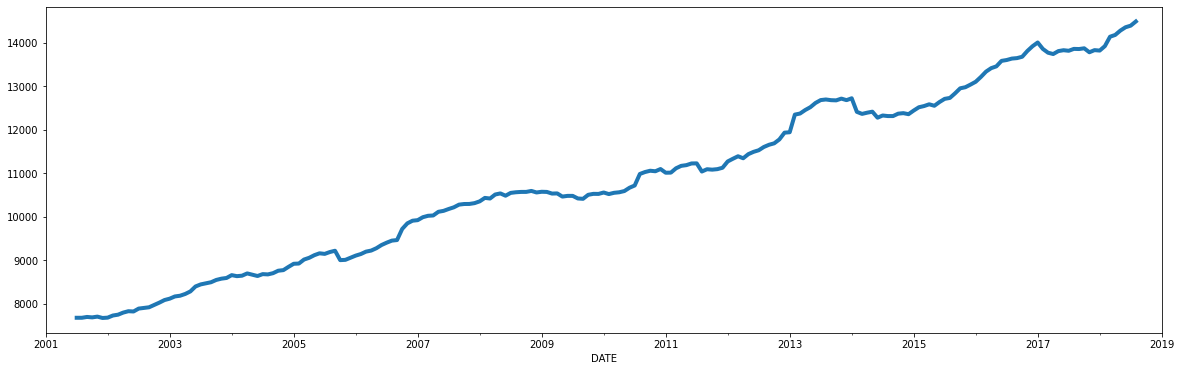

In [70]:
mobile_sales.Sales.rolling(12, center=True).mean().plot(linewidth=4)

In [73]:
trend = mobile_sales.Sales.rolling(12, center=True).mean()

In [74]:
de_trend = mobile_sales.Sales - trend

<AxesSubplot:xlabel='DATE'>

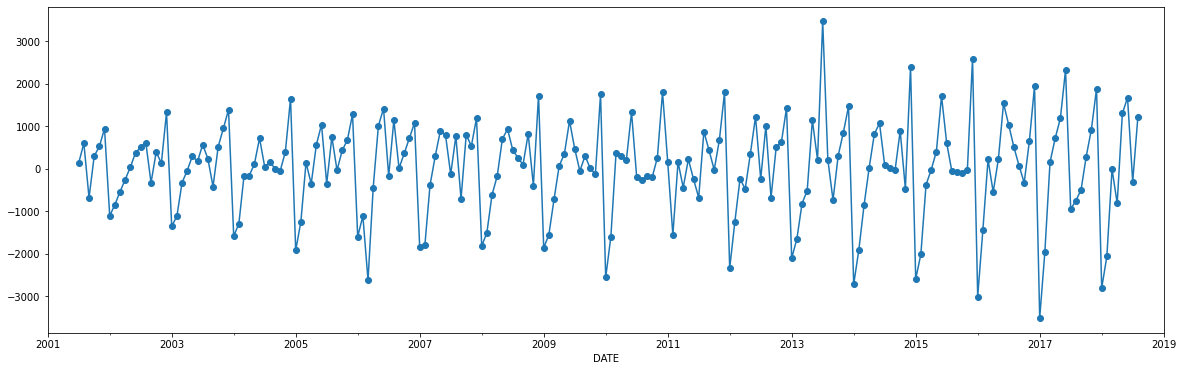

In [82]:
de_trend.plot(style='-o')

<AxesSubplot:>

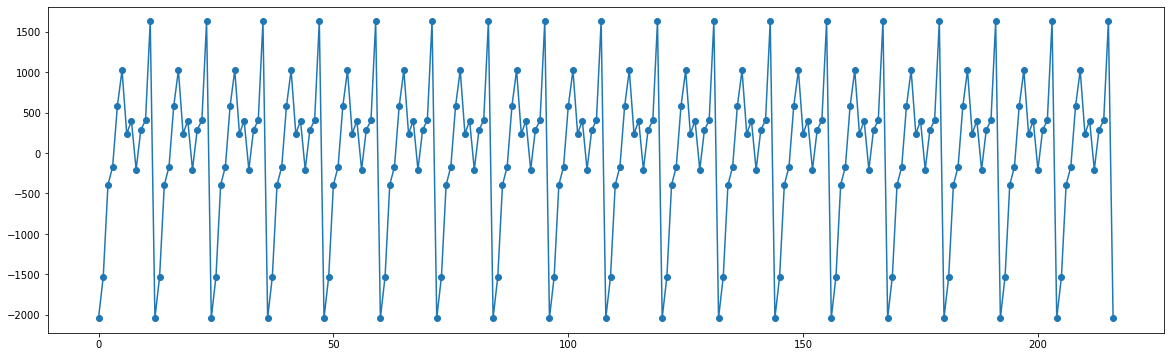

In [84]:
dtf = de_trend.reset_index()
dtf.groupby(dtf.DATE.dt.month).Sales.transform('mean').plot(style='-o')

In [85]:
seas = dtf.groupby(dtf.DATE.dt.month).Sales.transform('mean')

In [95]:
recreation = trend.reset_index().copy()
recreation['seas'] = seas
recreation.set_index('DATE', inplace=True)
recreation.columns = ['trend', 'seas']
recreation['y_hat'] = recreation['trend'] + recreation['seas']

<AxesSubplot:xlabel='DATE'>

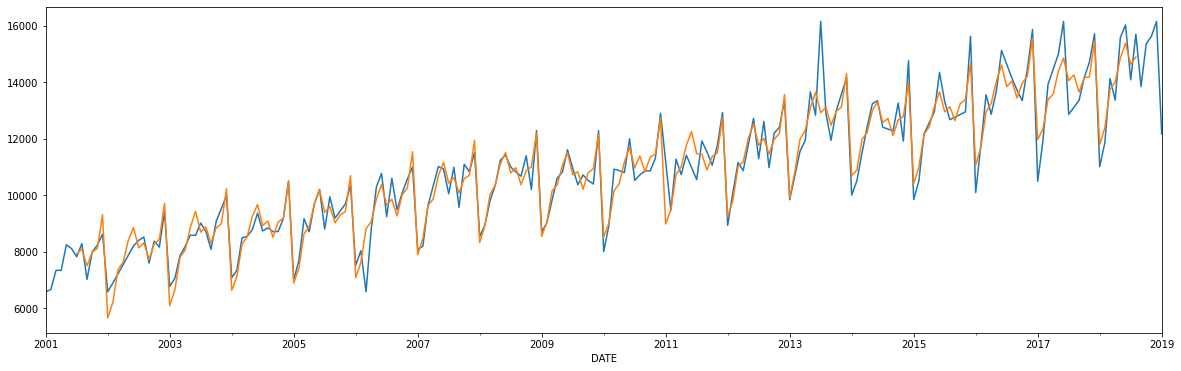

In [97]:
mobile_sales.Sales.plot()
recreation['y_hat'].plot()

In [99]:
import statsmodels.api as sm

In [139]:
model = sm.tsa.seasonal_decompose(mobile_sales.Sales, model='multiplicative')

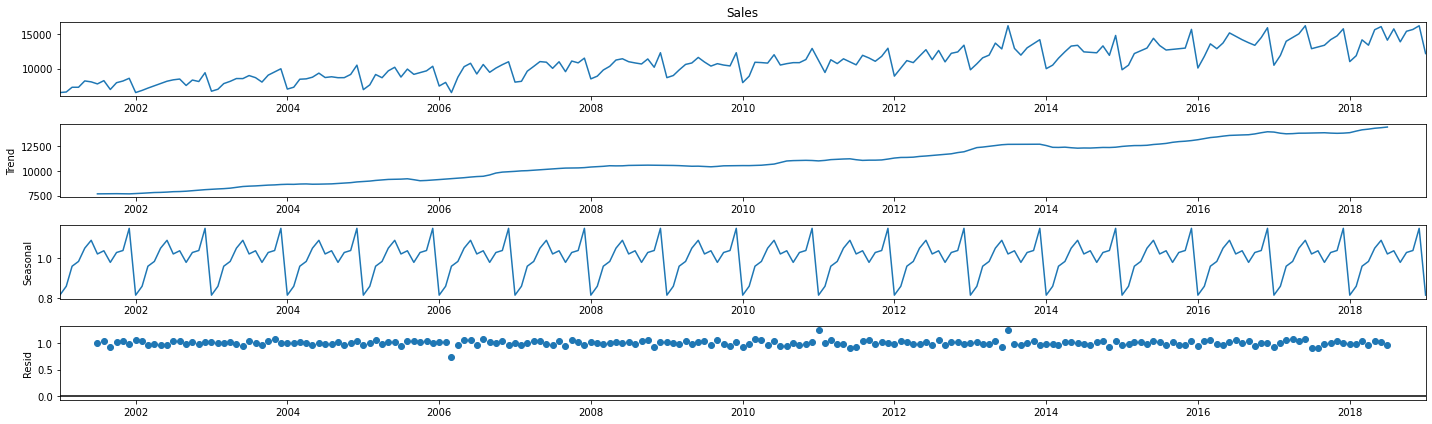

In [140]:
model.plot();

<AxesSubplot:xlabel='DATE'>

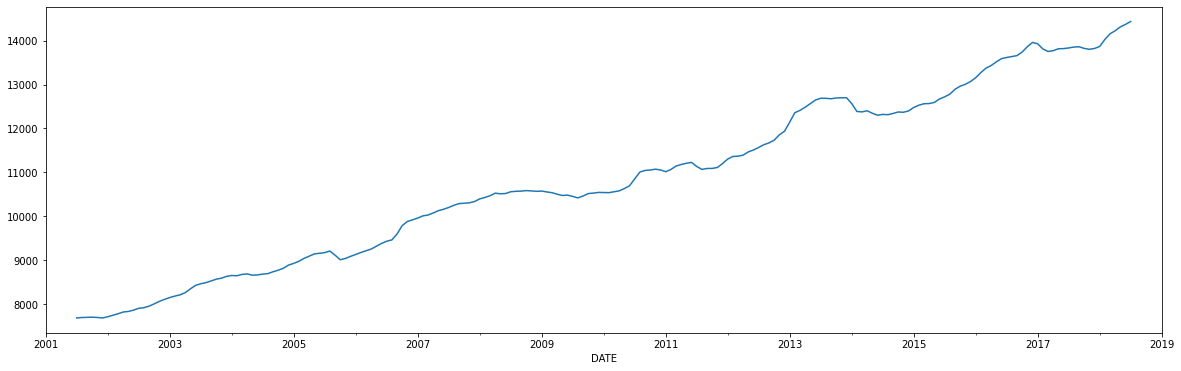

In [106]:
model.trend.plot()

<AxesSubplot:xlabel='DATE'>

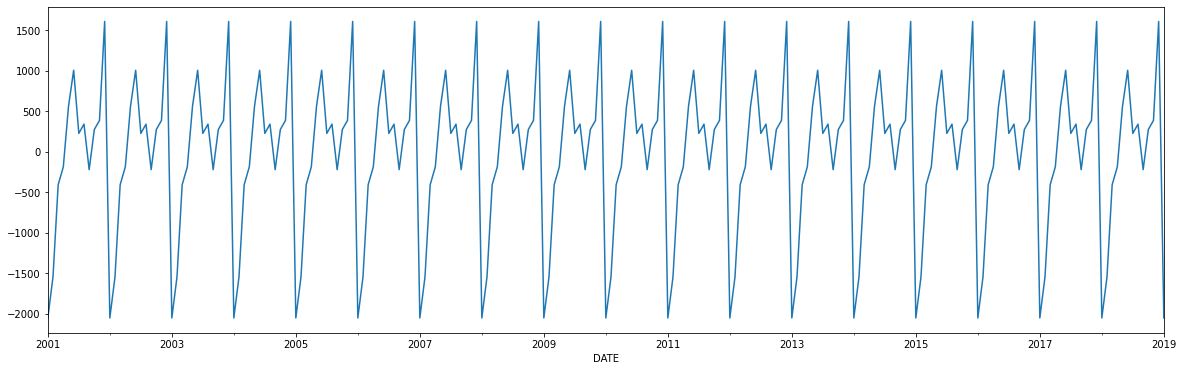

In [107]:
model.seasonal.plot()

<AxesSubplot:xlabel='DATE'>

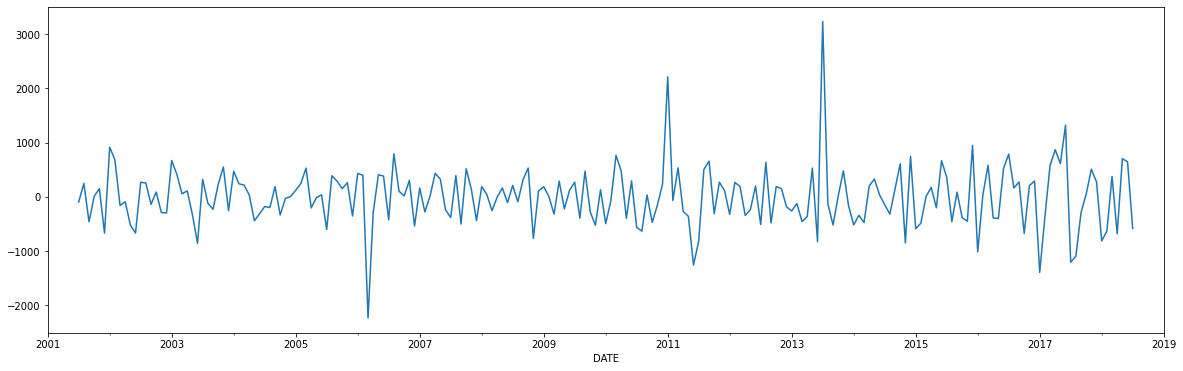

In [108]:
model.resid.plot()

# Simple Methods

In [115]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [116]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x.head()

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,16021.0


**naive method**

MAE : 3479.79
RMSE : 3757.483
MAPE: 0.232


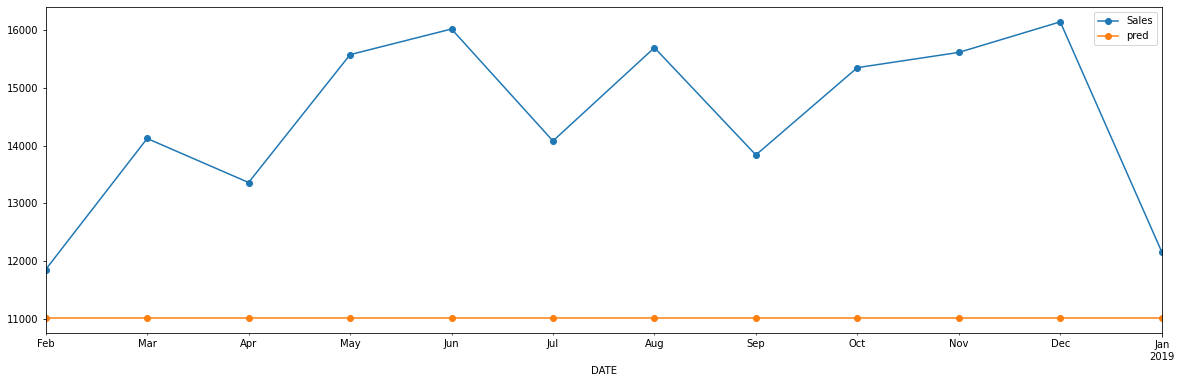

In [117]:
test_x['pred'] = train_x.Sales.iloc[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**mean method**

MAE : 3832.336
RMSE : 4086.14
MAPE: 0.257


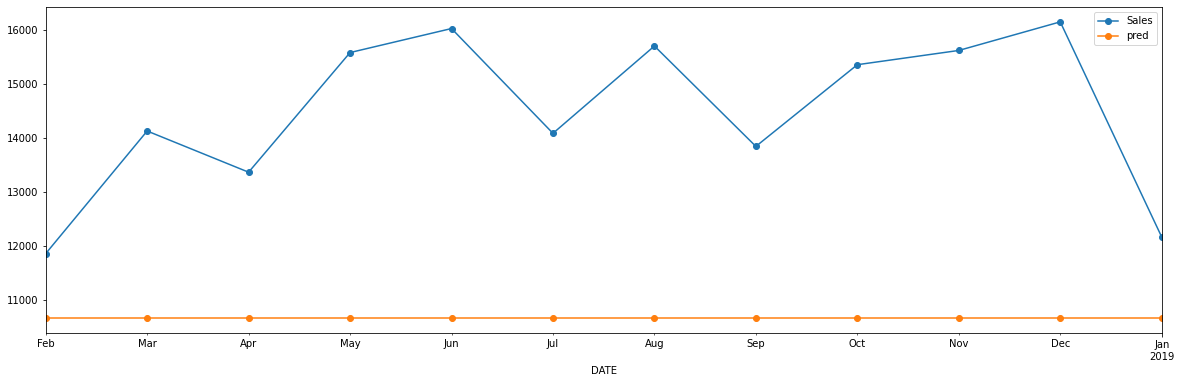

In [118]:
test_x['pred'] = train_x.Sales.mean()

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**drift method**

MAE : 3339.275
RMSE : 3620.726
MAPE: 0.223


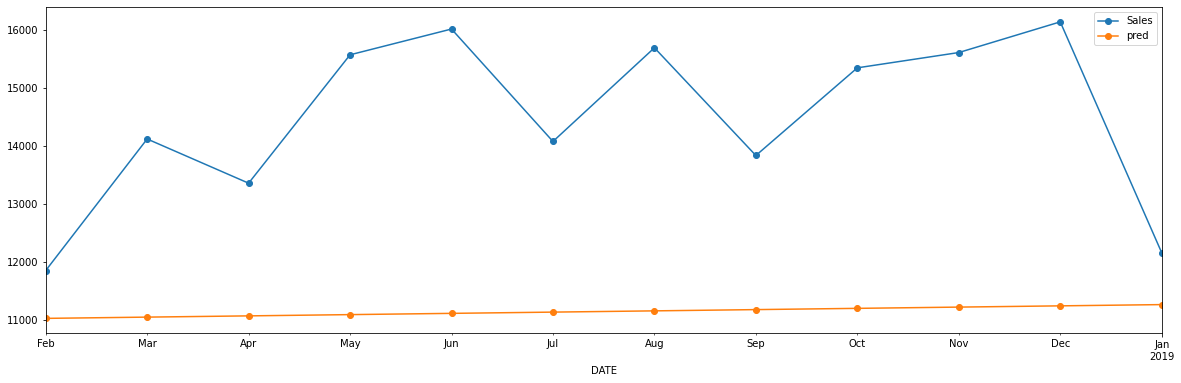

In [119]:
y_t = train_x.Sales.iloc[-1]
y_0 = train_x.Sales.iloc[0]

slope = (y_t - y_0) / len(train_x)
future = np.arange(1, 13)

pred = y_t + slope*future
test_x['pred'] = pred

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**seasonal naive**

MAE : 839.08
RMSE : 1075.542
MAPE: 0.058


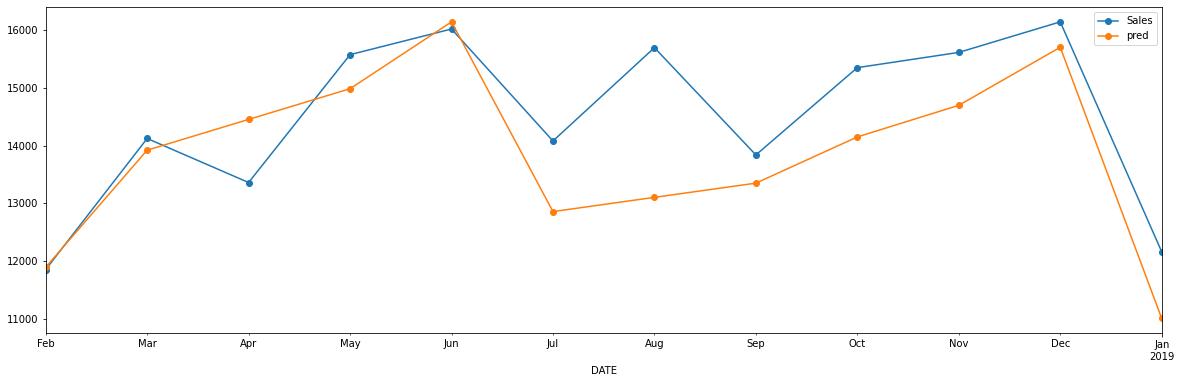

In [124]:
for i in test_x.index:
    test_x.loc[i]['pred'] = train_x.loc[i - pd.DateOffset(years=1)]['Sales']

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**moving average**

MAE : 1738.024
RMSE : 1940.885
MAPE: 0.117


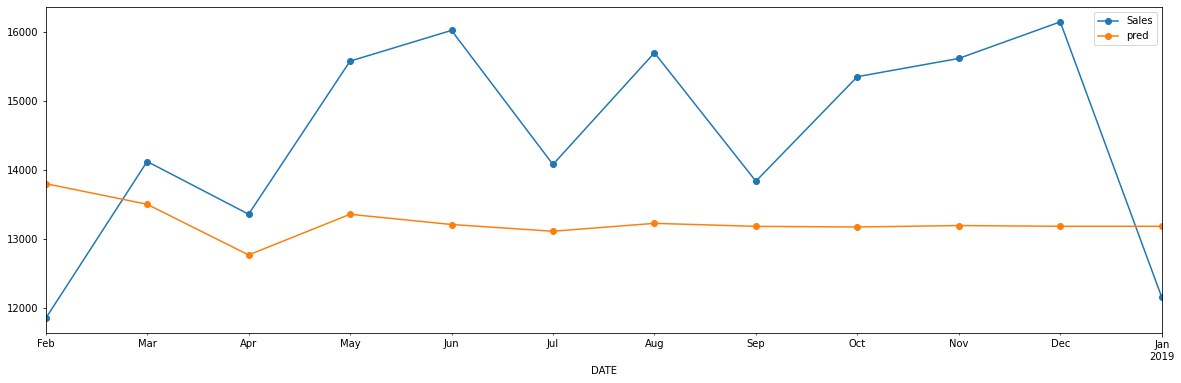

In [129]:
pred = train_x.Sales.values
w = 3

for i in range(12):
    pred = np.append(pred, pred[-w:].mean())
    
test_x['pred'] = pred[-12:]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

# Smoothing Methods

**SES**

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


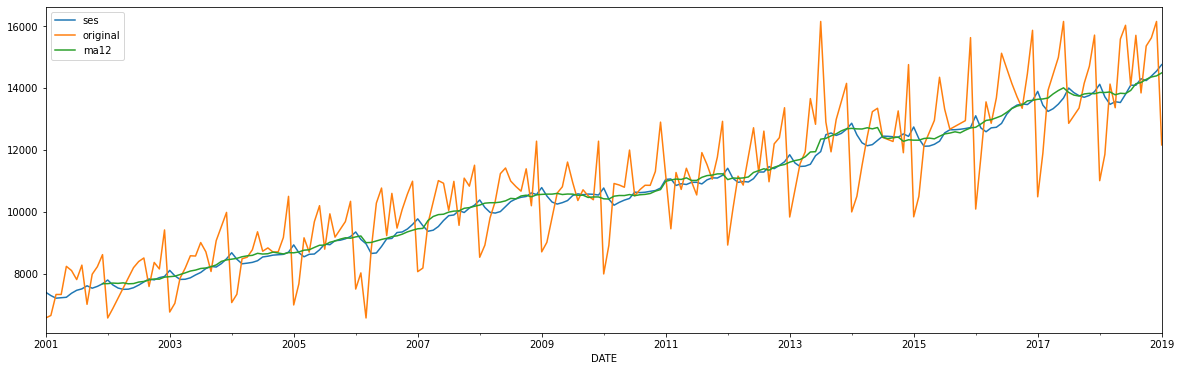

In [145]:
pred = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit().fittedvalues)

pred.plot(label='ses')
mobile_sales.Sales.plot(label='original')
mobile_sales.Sales.rolling(12).mean().plot(label='ma12')
plt.legend()

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


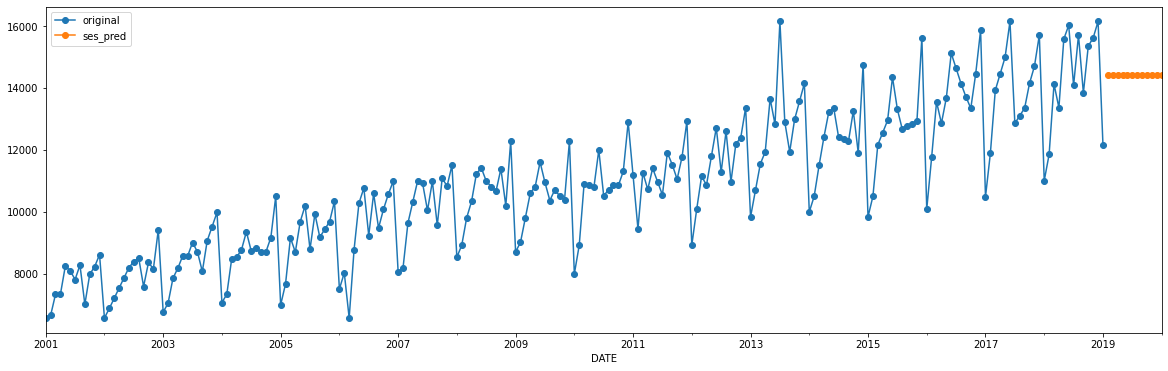

In [146]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit()
pred = model.forecast(12)

mobile_sales.Sales.plot(label='original', style='-o')
pred.plot(label='ses_pred', style='-o')
plt.legend()

MAE : 1400.657
RMSE : 1615.114
MAPE: 0.095


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


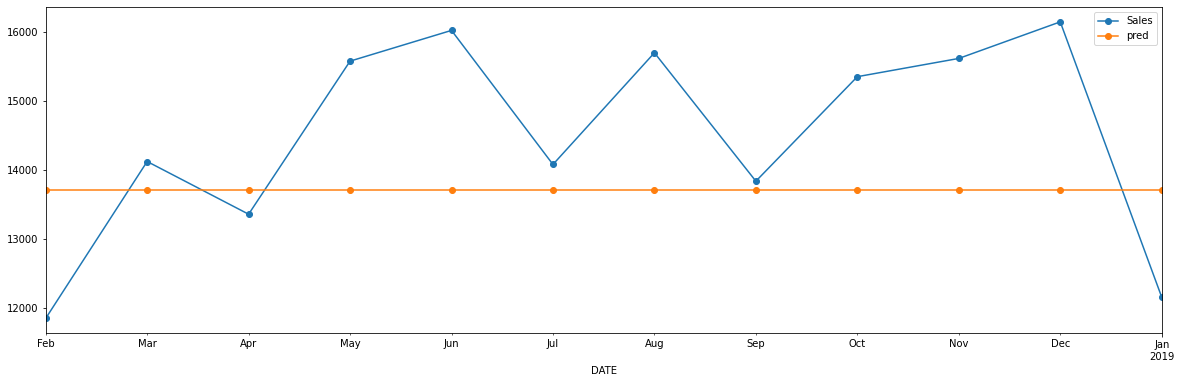

In [148]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit()
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**DES**

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


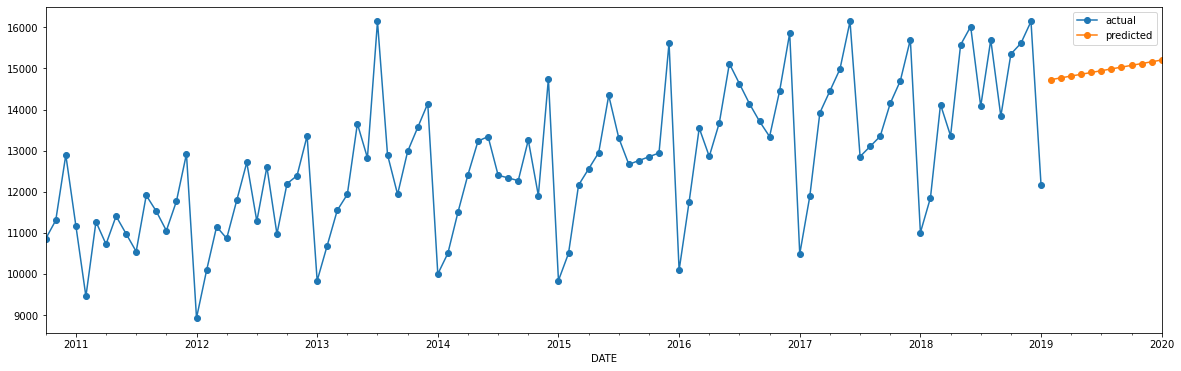

In [150]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit()
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

MAE : 1211.111
RMSE : 1407.517
MAPE: 0.086


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


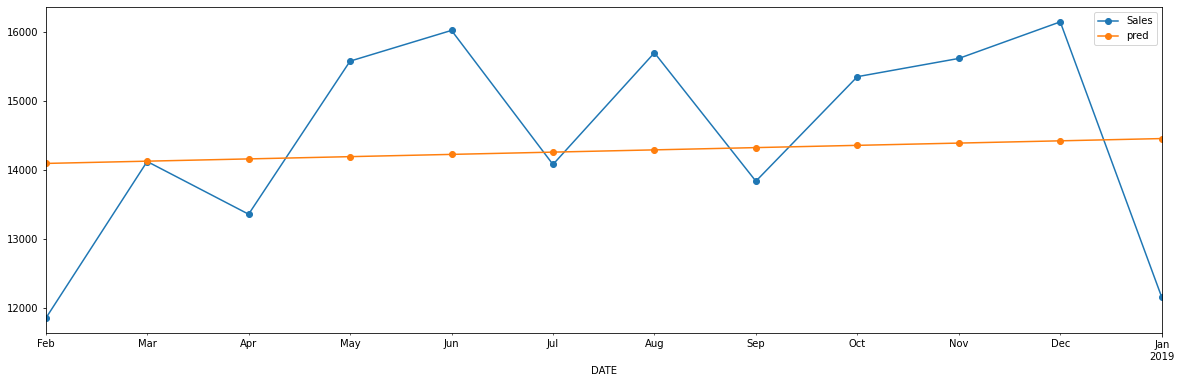

In [151]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit()
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**TES**

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


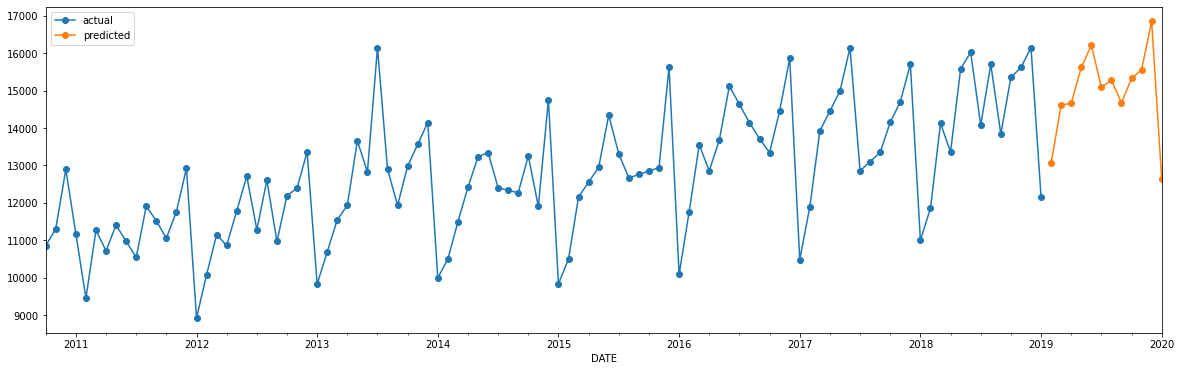

In [152]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit()
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

MAE : 582.42
RMSE : 682.349
MAPE: 0.039


/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


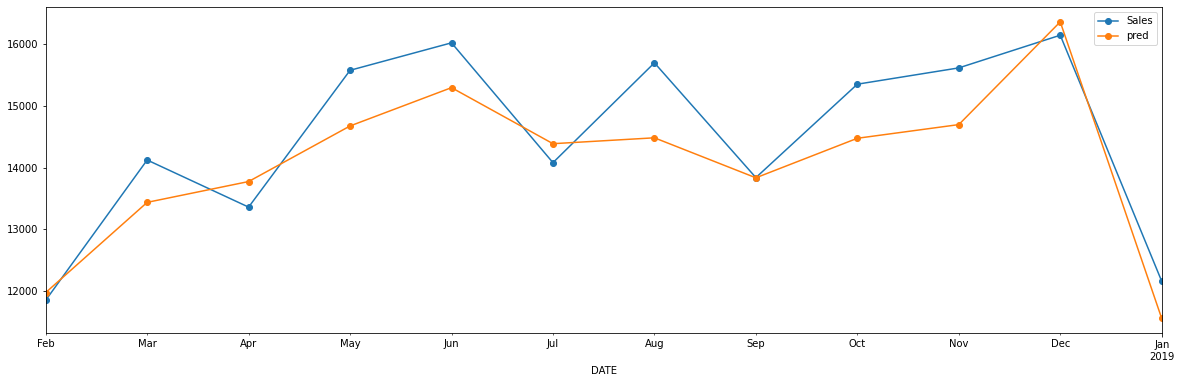

In [154]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit()
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## Stationarity

In [157]:
def adf_test(data, significance_level=0.05):
    p_value = sm.tsa.stattools.adfuller(data)[1]
    if p_value < significance_level:
        print('Sequence is Stationary')
    else:
        print('Sequence is not Stationary')

In [158]:
adf_test(mobile_sales.Sales)

Sequence is not Stationary


## Auto Correlation Function

In [159]:
mobile_sales.Sales.head()

DATE
2001-01-01    6573.36
2001-02-01    6654.00
2001-03-01    7332.00
2001-04-01    7332.00
2001-05-01    8240.00
Name: Sales, dtype: float64

In [160]:
mobile_sales.Sales.shift().head()

DATE
2001-01-01        NaN
2001-02-01    6573.36
2001-03-01    6654.00
2001-04-01    7332.00
2001-05-01    7332.00
Name: Sales, dtype: float64

In [169]:
x = pd.DataFrame()
x['next'] = mobile_sales.Sales
x['previuos'] = mobile_sales.Sales.shift(1)
x['previuos_2'] = mobile_sales.Sales.shift(2)
x.head()

,next,previuos,previuos_2
DATE,,,
2001-01-01,6573.36,NaN,NaN
2001-02-01,6654.00,6573.36,NaN
2001-03-01,7332.00,6654.00,6573.36
2001-04-01,7332.00,7332.00,6654.00
2001-05-01,8240.00,7332.00,7332.00


**Auto Correlation Function**

In [173]:
corr = []
for lag in range(40):
    corr.append(np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag).dropna())[0][1])

<StemContainer object of 3 artists>

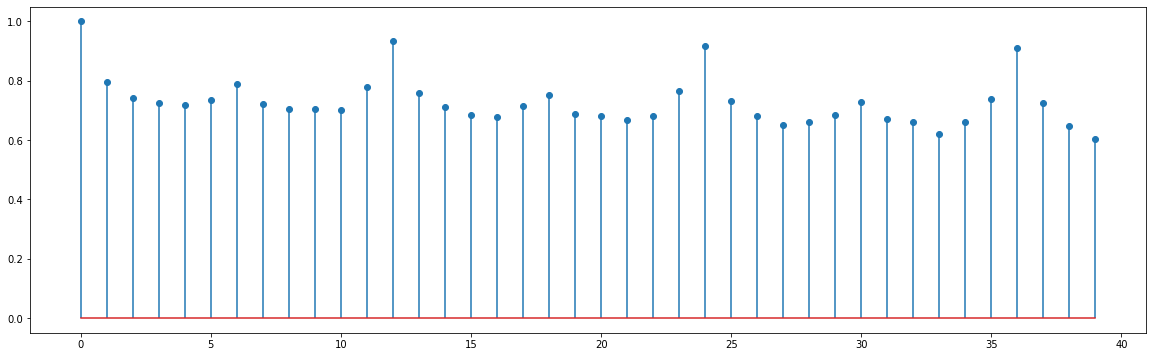

In [175]:
plt.stem(corr)

In [177]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

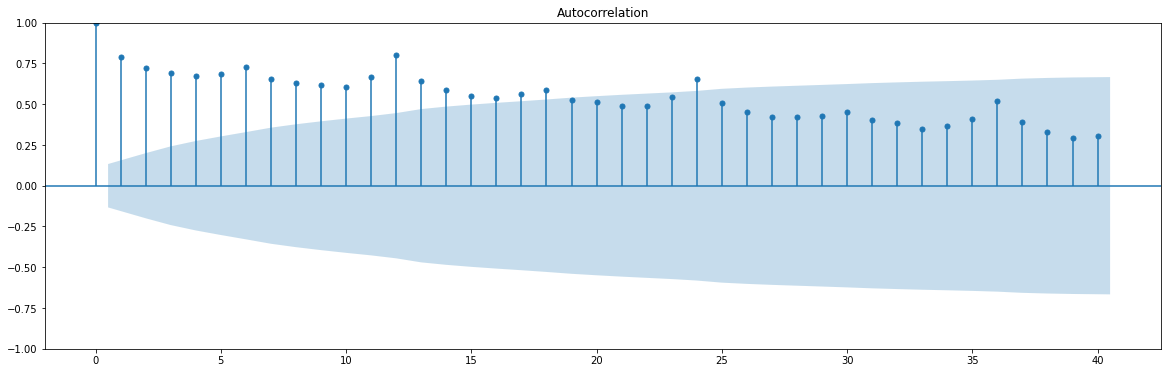

In [179]:
plot_acf(mobile_sales.Sales, lags=40);

**Partial AutoCorrelation**

-- Adjusts for chained dependency i.e. -- fixes multi colinearity

/Users/gyanarora/miniconda3/envs/scaler/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


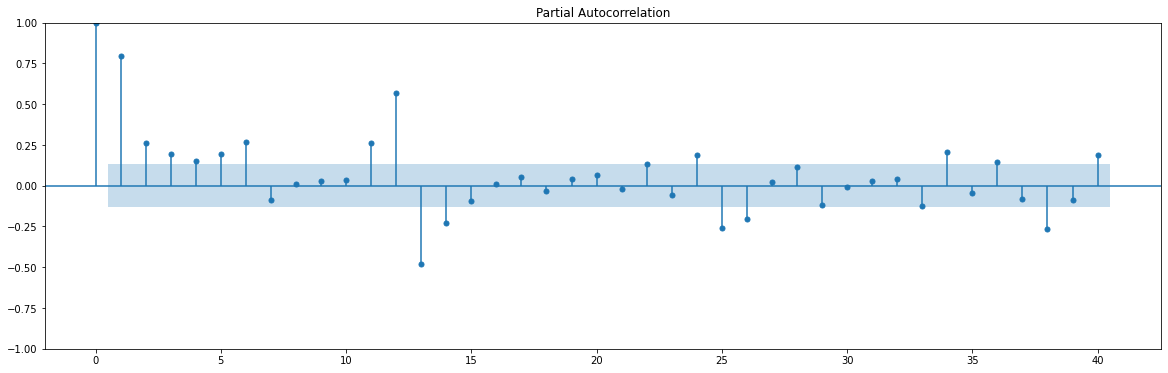

In [180]:
plot_pacf(mobile_sales.Sales, lags=40);

In [ ]:
can you apply == auto-correlation AR(p) on this time series ????

stationarise it -- apply this

In [ ]:
google -- hard to predict
diff(google) - AR(p) -- pred --integrate -- maybe more accurate
